# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV into DataFrame

In [3]:
# Load the data
file_path = Path('Resources/lending_data.csv')
df = pd.read_csv(file_path)
df.head()

,loan_size,interest_rate,homeowner,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,own,52800,0.431818,5,1,22800,low_risk
1,8400.0,6.692,own,43600,0.311927,3,0,13600,low_risk
2,9000.0,6.963,rent,46100,0.349241,3,0,16100,low_risk
3,10700.0,7.664,own,52700,0.430740,5,1,22700,low_risk
4,10800.0,7.698,mortgage,53000,0.433962,5,1,23000,low_risk


# Split the Data into Training and Testing

In [4]:
# Create our features
X = df.drop(columns=["loan_status", "homeowner"])

# Create our target
y = df.loan_status.to_frame()

In [5]:
X.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000


In [6]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     75036
high_risk     2500
Name: loan_status, dtype: int64

In [7]:
# Create X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [8]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()

In [9]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
data_scaler.fit(X_train, X_test)

StandardScaler()

In [10]:
# Scale the training and testing data
X_train = data_scaler.transform(X_train)
X_train[:5]

X_test = data_scaler.transform(X_test)
X_test[:5]

array([[ 1.33383057,  1.32170668,  1.32215708,  1.53620797,  1.14084852,
         1.04334691,  1.32215708],
       [-0.00381349, -0.00491964, -0.00379305,  0.15702536,  0.09035056,
        -0.67289855, -0.00379305],
       [ 0.52168953,  0.53584922,  0.5337543 ,  0.7848731 ,  0.61559954,
         1.04334691,  0.5337543 ],
       [ 0.42614353,  0.41892623,  0.41429933,  0.65461753,  0.61559954,
         1.04334691,  0.41429933],
       [ 0.04395951,  0.06703297,  0.06787993,  0.24729423,  0.09035056,
        -0.67289855,  0.06787993]])

# Simple Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [12]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9889115309798473

<AxesSubplot:>

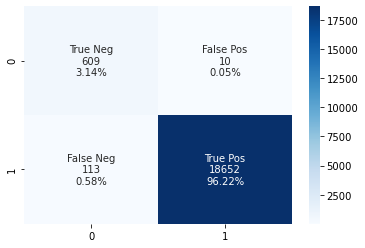

In [13]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Boilerplate code for plotting a confusion matrix heatmap
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

It seems that this model did very well at predicting the risk values for each loan. With only 0.63% incorrect predictions

In [14]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.84      0.98      0.99      0.91      0.99      0.98       619
   low_risk       1.00      0.99      0.98      1.00      0.99      0.98     18765

avg / total       0.99      0.99      0.98      0.99      0.99      0.98     19384



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [15]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_resampled)
y_resampled.shape

(112542, 1)

In [16]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_resampled)

In [17]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_resampled, y_pred)

0.9947130848927511

<AxesSubplot:>

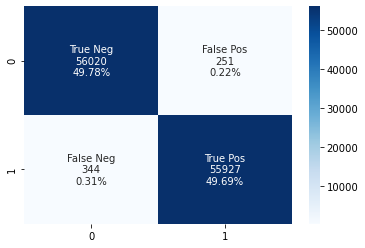

In [18]:
# Display the confusion matrix
cf_matrix = confusion_matrix(y_resampled, y_pred)

# Boilerplate confusion matrix heatmap
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [19]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_resampled, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.99      1.00      0.99      0.99      0.99      0.99     56271
   low_risk       1.00      0.99      1.00      0.99      0.99      0.99     56271

avg / total       0.99      0.99      0.99      0.99      0.99      0.99    112542



I am very impressed with how well the random over sampling affected the model's ability to predict, 99% accuracy is very good, and this model could be used for real world application

### SMOTE Oversampling

In [20]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train, y_train
)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({'loan_status': 1})

In [21]:
y_resampled.shape

(112542, 1)

In [22]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [23]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_resampled)
balanced_accuracy_score(y_resampled, y_pred)

0.9947575127507953

<AxesSubplot:>

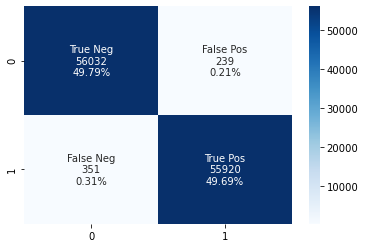

In [24]:
# Display the confusion matrix
cf_matrix = confusion_matrix(y_resampled, y_pred)

# Boilerplate confusion matrix heatmap
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [25]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_resampled, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.99      1.00      0.99      0.99      0.99      0.99     56271
   low_risk       1.00      0.99      1.00      0.99      0.99      0.99     56271

avg / total       0.99      0.99      0.99      0.99      0.99      0.99    112542



# Undersampling

In this section, you will test an undersampling algorithm to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [26]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({'loan_status': 1})

In [27]:
y_resampled.shape

(3762, 1)

In [28]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [29]:
# Calculate the balanced accuracy score
y_pred = model.predict(X_resampled)
balanced_accuracy_score(y_resampled, y_pred)

0.9423179160021266

<AxesSubplot:>

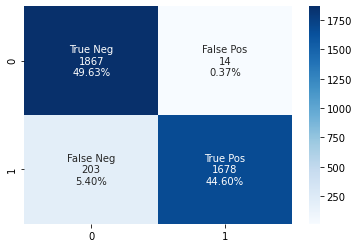

In [30]:
# Display the confusion matrix
cf_matrix = confusion_matrix(y_resampled, y_pred)

# Boilerplate confusion matrix heatmap
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [31]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_resampled, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.90      0.99      0.89      0.95      0.94      0.89      1881
   low_risk       0.99      0.89      0.99      0.94      0.94      0.88      1881

avg / total       0.95      0.94      0.94      0.94      0.94      0.89      3762



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [32]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({'loan_status': 1})

In [37]:
y_resampled.shape

(111361, 1)

In [33]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [34]:
# Calculate the balanced accuracy score
y_pred = model.predict(X_resampled)
balanced_accuracy_score(y_resampled, y_pred)

0.9983691025037036

<AxesSubplot:>

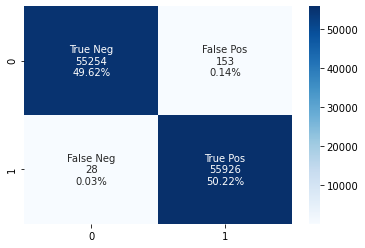

In [35]:
# Display the confusion matrix
cf_matrix = confusion_matrix(y_resampled, y_pred)

# Boilerplate confusion matrix heatmap
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [36]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_resampled, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       1.00      1.00      1.00      1.00      1.00      1.00     55407
   low_risk       1.00      1.00      1.00      1.00      1.00      1.00     55954

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    111361



Wow! Incredibly impressed with the SMOTEENN combination resampling

# Final Questions

1. Which model had the best balanced accuracy score?

   SMOTEENN had the best balanced accuracy score, coming in at a whopping 0.998
   This is incredible. Every model did a great job and all had very high balanced accuracy scores, but it has been really cool to see tangible difference that resampling can make

2. Which model had the best recall score?

    Again SMOTEENN blew it out of the water with a recall score of 1.0
    This means that the model predicted 0 false negatives.

3. Which model had the best geometric mean score?

    SMOTEENN again


### Sidenote

I realised that I had been using the non scaled data for all of these models, scores were very similar and in fact SMOTEENN had a slightly better score with non scaled data at 0.999.

But I changed the code to use the scaled data from StandardScaler() for all of the models